**Data :**
*WalkingSittingStanding* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=WalkingSittingStanding)

For reference, a MiniRocket classifier gets accuracy of 92.7% on the default test data.

Best so far : 60 % accuracy

- the loss function does not have a smooth profile 
- parameter tuning on the optimisation and, size, number of channels and loss parameters

In [1]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt

In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data", "WalkingSittingStanding")
train_file = "WalkingSittingStanding_TRAIN.ts"
test_file = "WalkingSittingStanding_TEST.ts"

In [3]:
tsx_train, y_train = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test = load_from_tsfile(os.path.join(data_dir, test_file))
y_train = y_train.astype(float)
y_test = y_test.astype(float)
tsx_train.shape, len(y_test)

((7352, 3, 206), 2947)

In [4]:
# local imports
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

from development.nn import development_layer
from development.so import so

In [5]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torch import optim
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [6]:
tsx_train = Tensor(tsx_train).swapaxes(1, 2)
tsx_test = Tensor(tsx_test).swapaxes(1, 2)

y_train = Tensor(y_train)
y_test = Tensor(y_test)

In [111]:
len(y_train), len(y_test)

(7352, 2947)

In [138]:
import random


def generate_derangement(n):
    while True:
        # Generate a random permutation of elements
        perm = list(range(n))
        random.shuffle(perm)

        # Check if it's a derangement
        if all(perm[i] != i for i in range(n)):
            return perm


def train_model_multichannels(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.2,
    beta=0.5,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y0 = X[labels == 0]
            Y1 = X[labels == 1]
            Y2 = X[labels == 2]
            Y3 = X[labels == 3]
            Y4 = X[labels == 4]
            Y5 = X[labels == 5]

            tau_0 = torch.mean(Y0, axis=0) if len(Y0) > 0 else torch.zeros_like(X[0])
            tau_1 = torch.mean(Y1, axis=0) if len(Y1) > 0 else torch.zeros_like(X[0])
            tau_2 = torch.mean(Y2, axis=0) if len(Y2) > 0 else torch.zeros_like(X[0])
            tau_3 = torch.mean(Y3, axis=0) if len(Y3) > 0 else torch.zeros_like(X[0])
            tau_4 = torch.mean(Y4, axis=0) if len(Y4) > 0 else torch.zeros_like(X[0])
            tau_5 = torch.mean(Y5, axis=0) if len(Y5) > 0 else torch.zeros_like(X[0])

            tau = torch.stack([tau_0, tau_1, tau_2, tau_3, tau_4, tau_5])
            dtau = tau - tau[generate_derangement(6)]
            nclass, nchannels, _, _ = dtau.shape
            dtau = dtau.reshape((nclass * nchannels, hidden_size, hidden_size))
            dtau0 = tau_0 - Y0
            dtau1 = tau_1 - Y1
            dtau2 = tau_2 - Y2
            dtau3 = tau_3 - Y3
            dtau4 = tau_4 - Y4
            dtau5 = tau_5 - Y5

            b, c, d, _ = X.shape

            loss = (
                -(1 - beta)
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                / hidden_size
                / b
                - beta
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                ** 2
                / hidden_size
                / b
            )
            for dt in [dtau0, dtau1, dtau2, dtau3, dtau4, dtau5]:
                loss += (
                    alpha
                    * torch.norm(
                        torch.swapaxes(dt.reshape((len(dt) * c, d, d)), 1, 2)
                        .bmm(dt.reshape((len(dt) * c, d, d)))
                        .diagonal(dim1=1, dim2=2)
                        .sum(-1)
                    )
                    ** 2
                    / hidden_size
                    / len(dt)
                )
            loss.backward()
            optimizer.step()

            lossx.append(loss.item() / b)

        if verbose:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.sum(lossx[-1000:]) / 1000}"
            )

    return lossx

In [145]:
# build the dataset
batch_size = 128
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [ ]:
class DevNetMultipleLayers(nn.Module):
    def __init__(self, dev_layer):
        super().__init__(self)
        self.dev_layer = dev_layer
        self.hidden_sizew = dev_layer.hidden_size
        # add an attention layer on the channels before doing the average
        # will allow to select the best samples without having to shift all
        # of them in a coherent direction
        # risk of overfittin
        self.attention = Attention

    def forward(self, x):
        x = self.dev_layer(x)
        x = self.linear(x)
        return x

    def partial_forward(self, x):
        return self.dev_layer(x)

In [151]:
hidden_size = 3
nchannels = 2
dev_layer = development_layer(
    input_size=3,
    hidden_size=hidden_size,
    channels=nchannels,
    param=so,
    complexification=False,
    return_sequence=False,
)

Epoch [1/20], Loss: 1.9914130808891577e-06
Epoch [2/20], Loss: 2.9093213177994974e-06
Epoch [3/20], Loss: 2.62892850501625e-06
Epoch [4/20], Loss: 1.812945971063789e-07
Epoch [5/20], Loss: -5.752734775342105e-06
Epoch [6/20], Loss: -1.7069476370644614e-05
Epoch [7/20], Loss: -3.5138623947854546e-05
Epoch [8/20], Loss: -6.652561336925699e-05
Epoch [9/20], Loss: -0.00012126594146983343
Epoch [10/20], Loss: -0.00022533766760261643
Epoch [11/20], Loss: -0.0004385006864612089
Epoch [12/20], Loss: -0.000857630077828357
Epoch [13/20], Loss: -0.0015585841528995197
Epoch [14/20], Loss: -0.002602933593139954
Epoch [15/20], Loss: -0.0036237144429426605
Epoch [16/20], Loss: -0.004635587286648843
Epoch [17/20], Loss: -0.005704555690250995
Epoch [18/20], Loss: -0.006785537233218878
Epoch [19/20], Loss: -0.007867935281221176
Epoch [20/20], Loss: -0.008844925411945951


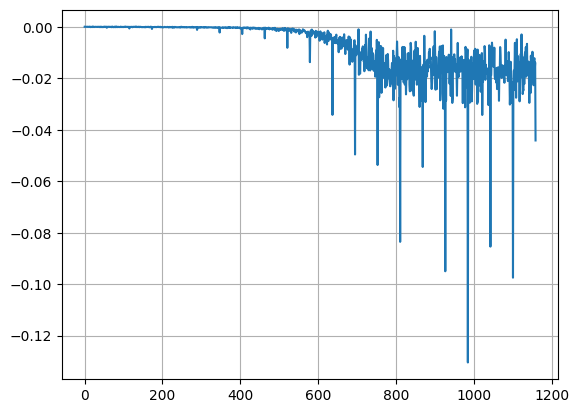

In [152]:
# optimizer = optim.Adam(dev_layer.parameters(), lr=0.002)
optimizer = optim.SGD(dev_layer.parameters(), lr=0.0001, momentum=0.99)

lossx = train_model_multichannels(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=20, alpha=0.08, beta=0.6
)
_, ax = plt.subplots()
ax.plot(range(len(lossx)), lossx)
ax.grid()

In [153]:
dev_layer.eval()

dev_train = dev_layer(tsx_train)
dt0 = dev_train[y_train == 0]
dt1 = dev_train[y_train == 1]
dt2 = dev_train[y_train == 2]
dt3 = dev_train[y_train == 3]
dt4 = dev_train[y_train == 4]
dt5 = dev_train[y_train == 5]
tau0 = torch.mean(dt0, axis=0)
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)
tau3 = torch.mean(dt3, axis=0)
tau4 = torch.mean(dt4, axis=0)
tau5 = torch.mean(dt5, axis=0)

diff0 = (dev_train - tau0).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff3 = (dev_train - tau3).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff4 = (dev_train - tau4).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff5 = (dev_train - tau5).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

dd0 = (
    torch.swapaxes(diff0, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd3 = (
    torch.swapaxes(diff3, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd4 = (
    torch.swapaxes(diff4, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd5 = (
    torch.swapaxes(diff5, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

dd = torch.stack([dd0, dd1, dd2, dd3, dd4, dd5])
c = dd.argmin(dim=0)
print("train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

dev_test = dev_layer(tsx_test)

diff0 = (dev_test - tau0).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff3 = (dev_test - tau3).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff4 = (dev_test - tau4).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff5 = (dev_test - tau5).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

dd0 = (
    torch.swapaxes(diff0, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd3 = (
    torch.swapaxes(diff3, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd4 = (
    torch.swapaxes(diff4, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd5 = (
    torch.swapaxes(diff5, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

dd_test = torch.stack([dd0, dd1, dd2, dd3, dd4, dd5])
c_test = dd_test.argmin(dim=0)
print("test accuracy : ", (y_test.numpy() == c_test.numpy()).sum() / len(y_test))

train accuracy :  0.6067736670293797
test accuracy :  0.5955208686800135


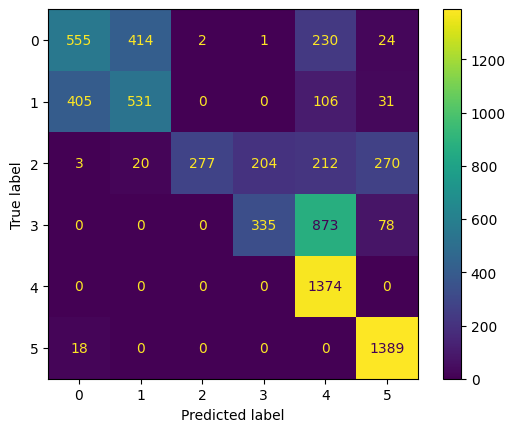

In [154]:
cm = confusion_matrix(y_train, c)
ConfusionMatrixDisplay(cm).plot()

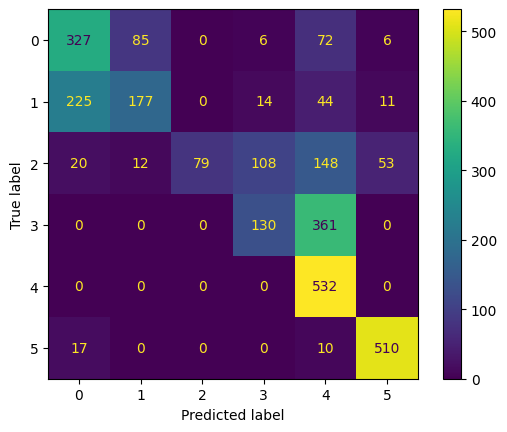

In [155]:
cm_test = confusion_matrix(y_test, c_test)
ConfusionMatrixDisplay(cm_test).plot()